# Anomaly Detection 📍

##  Objective
In this notebook, as a second approach, we aim to develop machine learning models capable of identifying erroneous data points within our ornithological datasets. Unlike our previous approach that primarily focused on temporal and spatial information through Emergent Filters, this machine learning approach employs anomaly detection algorithms such as Isolation Forests, One-Class SVM, and autoencoders. These algorithms enable us to incorporate more sophisticated features, including those provided by ornitho.de (such as Atlas Code) and self-created features derived from them (like land use, weather, and altitude), into the anomaly detection process.

## Scope
Our investigation aims to achieve two significant outcomes. Firstly, we intend to accurately distinguish between valid and invalid data points using afore-mentioned anomaly detection algorithms. Secondly, we aim to augment our anomaly detection process with interpretability. We employ Shapley values to unravel the decision-making process of our models, pinpointing the pivotal features that lead to the classification of a data point as erroneous. This transparent approach not only provides valuable insights for model evaluation but also potentially provides additional assistance to reviewers during error assessment.

Creating specialized anomaly detection models for individual bird species enables us to capture their unique behavioral nuances and identify specific patterns associated for each species. We have chosen to prototype our model implementation for the water pipit (ger. *Bergpieper*), one of the 27 bird species selected by ornitho.de and ornitho.ch.

***

You can download the data needed to run this code [here](https://drive.google.com/drive/folders/18XoTsDtWnN4QdIBNGGbq-jaa6U3nVb2e).<br>

In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "Itim"
    }
</style>

In [2]:
%reload_ext autoreload

import sys
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import pandas as pd
import plotly.express as px
import shap
from sklearn.ensemble import IsolationForest

from utils.data_preparation import *
from simon.utils.feature_generation import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 1️⃣  Load and prepare data
For this notebook, we are using the standardized dataset containing bird sightings data from both Switzerland and Germany spanning from 2018 to 2022. Additionally, we load the validation dataset provided by ornitho.ch and ornitho.de, comprising both correct and manually falsified data points from 2023.

In [3]:
path_train = '../../../01_Data/datasets/selected_species_with_50km_grids.csv'
train_data = pd.read_csv(path_train, index_col=0, low_memory=False).reset_index(drop=True)

In [4]:
# Data we want to predict on
path_validata = '../../../01_Data/datasets/validata_ornitho_ch_2023.csv'
date_format = '%d.%m.%Y'  # ch: '%d.%m.%Y'; de: %m/%d/%Y

# Data we need for data preparation
path_translator_names = '../../../01_Data/translators/translation_species_names_de_vs_ch.csv'
path_eea_grids = '../../../01_Data/shp_files/grids/eea_europe_grids_50km/inspire_compatible_grid_50km.shp'

# Load and standardize validation data
validata = pd.read_csv(path_validata, delimiter=get_delimiter(path_validata), low_memory=False)
validata = standardize_data(validata, 
                            date_format=date_format,
                            path_translator_species_names=path_translator_names,
                            eea_shapefile_path=path_eea_grids)

In [5]:
train_data.date = pd.to_datetime(train_data.date).dt.dayofyear
validata.date = pd.to_datetime(validata.date).dt.dayofyear

In [6]:
train_data = train_data[train_data.name_species == 'Bergpieper']
validata = validata[validata.name_species == 'Bergpieper']

In [7]:
train_data.head()

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country,eea_grid_id
12,29658979,469,Bergpieper,1,NaN,52.321750,10.432800,place,0,2.0,NaN,106288,de,50kmE4350N3200
30,29661644,469,Bergpieper,1,NaN,49.144776,10.690435,square,0,3.0,NaN,70588,de,50kmE4350N2850
39,29653403,469,Bergpieper,1,NaN,51.022837,6.208935,place,0,1.0,NaN,63657,de,50kmE4050N3100
41,29677384,469,Bergpieper,1,NaN,51.022837,6.208935,place,0,1.0,NaN,40350,de,50kmE4050N3100
44,29681835,469,Bergpieper,1,NaN,49.872006,12.239931,precise,0,2.0,NaN,40956,de,50kmE4450N2950


# 2️⃣ Model V1: Coordinates & Date
Initially, we incorporate only the temporal and spatial features to enable a direct comparison with the Emergent Filters.

In [25]:
bergpieper_train = train_data[['date', 'coord_lat', 'coord_lon']]
bergpieper_test = validata[['date', 'coord_lat', 'coord_lon']]
bergpieper_train.head()

,date,coord_lat,coord_lon
12,1,52.321750,10.432800
30,1,49.144776,10.690435
39,1,51.022837,6.208935
41,1,51.022837,6.208935
44,1,49.872006,12.239931


In [26]:
model = IsolationForest(contamination='auto', random_state=0)
model.fit(bergpieper_train)

anomalies = model.predict(bergpieper_test)
falsified_data = bergpieper_test[anomalies == -1]  # inliers=1; outliers=-1

In [27]:
print('Number of detected anomalies:', len(falsified_data), '/', len(bergpieper_test))
print('Percentage of anomalies:', round(len(falsified_data)/len(bergpieper_test)*100,2), '%')

Number of detected anomalies: 366 / 6431
Percentage of anomalies: 5.69 %


 99%|===================| 6352/6431 [00:30<00:00]        

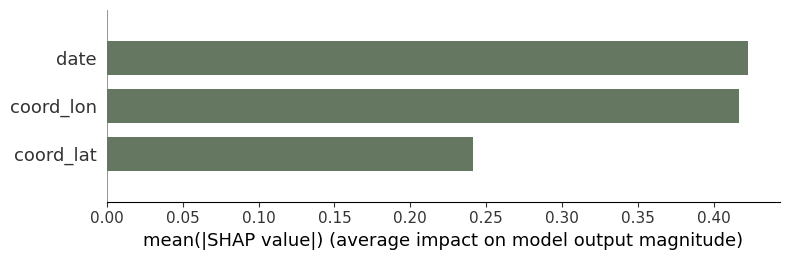

In [28]:
explainer = shap.Explainer(model, bergpieper_test)
shap_values = explainer.shap_values(bergpieper_test)

shap.summary_plot(shap_values, bergpieper_test, feature_names=bergpieper_test.columns, plot_type='bar', color='#667761')

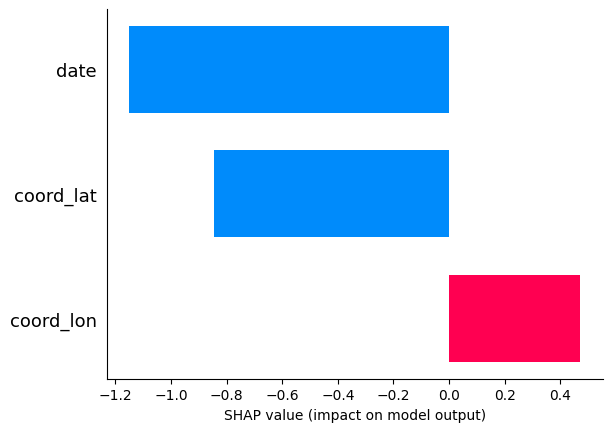

In [34]:
shap.initjs()
shap_values_dp = explainer.shap_values(bergpieper_test.iloc[4])
shap.bar_plot(shap_values_dp, feature_names=bergpieper_test.columns)

In [35]:
feature_names = bergpieper_test.columns
feature_index = np.argmax(np.abs(shap_values[1]))
feature_name = feature_names[feature_index]
print("Feature that contributed most to class -1:", feature_name)

Feature that contributed most to class -1: coord_lat


In [36]:
bergpieper_result = bergpieper_test.copy()
bergpieper_result['error_detected'] = model.predict(bergpieper_test)  # inlier 1 -> 0; outlier -1 -> 1
bergpieper_result['error_detected'] = bergpieper_result.error_detected.replace({1: 0, -1: 1})
bergpieper_result

,date,coord_lat,coord_lon,error_detected
16,191,47.567153,7.551575,0
509,84,46.155468,8.865485,0
510,104,46.162629,8.857722,0
511,77,46.163578,8.855934,0
512,31,46.162629,8.857658,0
...,...,...,...,...
87004,165,46.627150,8.422362,0
87019,101,46.811562,8.914987,0
87029,84,46.393022,7.849465,0
87034,184,46.577266,8.005193,0


In [37]:
feature_names = bergpieper_test.columns
outliers = bergpieper_result[bergpieper_result.error_detected == 1]

error_sources = []

for shaps in shap_values:
    if min(shaps) >=0:
        error_sources.append('None')
    else:
        feature_index = np.argmin(shaps)
        feature_name = feature_names[feature_index]
        error_sources.append(feature_name)

bergpieper_result['most_likely_error_source'] = error_sources
bergpieper_result.loc[bergpieper_result.error_detected == 0, 'most_likely_error_source'] = 'None'

bergpieper_result

,date,coord_lat,coord_lon,error_detected,most_likely_error_source
16,191,47.567153,7.551575,0,None
509,84,46.155468,8.865485,0,None
510,104,46.162629,8.857722,0,None
511,77,46.163578,8.855934,0,None
512,31,46.162629,8.857658,0,None
...,...,...,...,...,...
87004,165,46.627150,8.422362,0,None
87019,101,46.811562,8.914987,0,None
87029,84,46.393022,7.849465,0,None
87034,184,46.577266,8.005193,0,None


In [40]:
bergpieper_result[bergpieper_result.error_detected==1]

,date,coord_lat,coord_lon,error_detected,most_likely_error_source
525,25,46.162629,8.857671,1,date
1564,8,46.171996,8.876071,1,date
1566,1,46.165875,8.871377,1,date
1586,14,46.155402,8.864331,1,date
1590,1,46.171418,8.879824,1,date
...,...,...,...,...,...
86602,187,45.872056,7.166386,1,coord_lat
86654,190,45.935171,7.405672,1,coord_lat
86808,190,45.938193,7.406843,1,coord_lat
86829,190,45.938445,7.405708,1,coord_lat


In [41]:
# Plotly bar plot to show the error sources
import plotly.express as px

fig = px.pie(bergpieper_result, values='error_detected', names='most_likely_error_source', title='Error sources', color_discrete_sequence=['#667761', '#b79492', '#756460'])
fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                  title=dict(x=0.5, y=0.95, font=dict(size=24), text="Distribution of most likely error sources", xanchor='center'),
                  legend_title_text='Most Likely Error Source',
                  width=800, height=600)
fig.show()


In [42]:
fig = px.scatter_3d(bergpieper_result, x='date', y='coord_lon', z='coord_lat', color='most_likely_error_source',
                    opacity=0.7, width=800, height=600,
                    labels={'date': 'Date', 'coord_lon': 'Longitude', 'coord_lat': 'Latitude'},
                    title='Outlier Detection',
                    color_discrete_map={'None': '#d9d9d9'})

fig.update_traces(marker={'size': 2})   
fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                  title=dict(x=0.5, y=0.95, font=dict(size=24), text="Outlier Detection", xanchor='center'),
                  legend_title_text='Most Likely Error Source')

fig.show()

In [43]:
bergpieper_plot = bergpieper_result.copy()
bergpieper_plot['most_likely_error_source'] = bergpieper_plot.most_likely_error_source.replace(({'None': 'None (not an outlier)', 'coord_lat': 'None (not an outlier)'}))
fig = px.scatter(bergpieper_plot, x='date', y='coord_lon', color='most_likely_error_source',
                 opacity=0.7, width=800, height=300,
                 labels={'date': 'Date', 'coord_lon': 'Longitude'},
                 title='Outlier Detection',
                 color_discrete_map={'None (not an outlier)': '#d9d9d9'})

fig.update_traces(marker={'size': 8})  # Adjust marker size if needed
fig.update_layout(font=dict(family="Aleo", size=12, color="#4d5f81"),
                  title=dict(x=0.5, y=0.95, text="Outlier Detection based on date and longitude of sighting", xanchor='center'),
                  legend_title_text='Most Likely Error-Source',
                  margin=dict(t=50, b=10, l=10, r=10), legend=dict(x=0.766, y=0.98))

fig.show()

# 3️⃣ Model V2: Coordinates, Dates & Land Use

In [21]:
bergpieper_landuse_train = bergpieper_train.copy()
bergpieper_landuse_train = generate_land_use_clc(bergpieper_landuse_train)

In [22]:
bergpieper_landuse_test = bergpieper_test.copy()
bergpieper_landuse_test = generate_land_use_clc(bergpieper_landuse_test)

In [27]:
bergpieper_landuse_train

Index(['date', 'coord_lat', 'coord_lon', 'Numerical_LUSE', 'LUSE'], dtype='object')

In [29]:
model_luse = IsolationForest(contamination='auto', random_state=0)
model_luse.fit(bergpieper_landuse_train[['date', 'coord_lat', 'coord_lon', 'Numerical_LUSE']])

anomalies_luse = model_luse.predict(bergpieper_landuse_test[['date', 'coord_lat', 'coord_lon', 'Numerical_LUSE']])
falsified_data_luse = bergpieper_landuse_test[anomalies_luse == -1]  # inliers=1; outliers=-1

In [31]:
print('Number of detected anomalies:', len(falsified_data_luse), '/', len(bergpieper_landuse_test))
print('Percentage of anomalies:', round(len(falsified_data_luse)/len(bergpieper_landuse_test)*100,2), '%')

Number of detected anomalies: 586 / 6431
Percentage of anomalies: 9.11 %


 97%|=================== | 6248/6431 [00:30<00:00]       

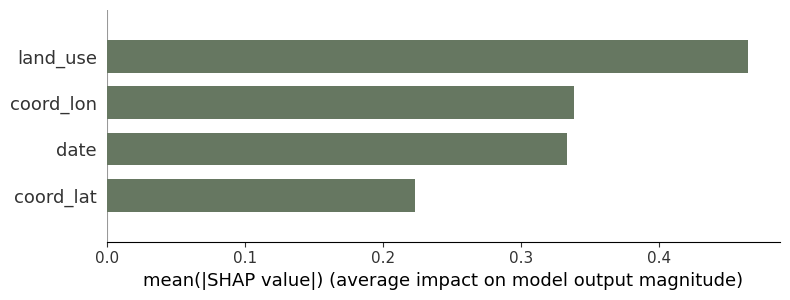

In [33]:
explainer = shap.Explainer(model_luse, bergpieper_landuse_test[['date', 'coord_lat', 'coord_lon', 'Numerical_LUSE']])
shap_values_luse = explainer.shap_values(bergpieper_landuse_test[['date', 'coord_lat', 'coord_lon', 'Numerical_LUSE']])

shap.summary_plot(shap_values_luse, bergpieper_landuse_test[['date', 'coord_lat', 'coord_lon', 'Numerical_LUSE']], feature_names=['date', 'coord_lat', 'coord_lon', 'land_use'], plot_type='bar', color='#667761')

In [44]:
bergpieper_result = bergpieper_landuse_test.copy()
bergpieper_result['error_detected'] = model_luse.predict(bergpieper_landuse_test[['date', 'coord_lat', 'coord_lon', 'Numerical_LUSE']])  # inlier 1 -> 0; outlier -1 -> 1
bergpieper_result['error_detected'] = bergpieper_result.error_detected.replace({1: 0, -1: 1})
bergpieper_result

,date,coord_lat,coord_lon,Numerical_LUSE,LUSE,error_detected
16,191,47.567153,7.551575,3,Agriculture,0
509,84,46.155468,8.865485,6,Water,0
510,104,46.162629,8.857722,6,Water,0
511,77,46.163578,8.855934,6,Water,0
512,31,46.162629,8.857658,6,Water,1
...,...,...,...,...,...,...
87004,165,46.627150,8.422362,6,Water,0
87019,101,46.811562,8.914987,6,Water,0
87029,84,46.393022,7.849465,6,Water,0
87034,184,46.577266,8.005193,6,Water,0


In [45]:
feature_names = bergpieper_landuse_test.columns
outliers = bergpieper_result[bergpieper_result.error_detected == 1]

error_sources = []

for shaps in shap_values_luse:
    if min(shaps) >=0:
        error_sources.append('None')
    else:
        feature_index = np.argmin(shaps)
        feature_name = feature_names[feature_index]
        error_sources.append(feature_name)

bergpieper_result['most_likely_error_source'] = error_sources
bergpieper_result.loc[bergpieper_result.error_detected == 0, 'most_likely_error_source'] = 'None'

bergpieper_result

,date,coord_lat,coord_lon,Numerical_LUSE,LUSE,error_detected,most_likely_error_source
16,191,47.567153,7.551575,3,Agriculture,0,None
509,84,46.155468,8.865485,6,Water,0,None
510,104,46.162629,8.857722,6,Water,0,None
511,77,46.163578,8.855934,6,Water,0,None
512,31,46.162629,8.857658,6,Water,1,date
...,...,...,...,...,...,...,...
87004,165,46.627150,8.422362,6,Water,0,None
87019,101,46.811562,8.914987,6,Water,0,None
87029,84,46.393022,7.849465,6,Water,0,None
87034,184,46.577266,8.005193,6,Water,0,None


In [46]:
# Plotly bar plot to show the error sources
import plotly.express as px

fig = px.pie(bergpieper_result, values='error_detected', names='most_likely_error_source', title='Error sources', color_discrete_sequence=['#667761', '#b79492', '#756460'])
fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                  title=dict(x=0.5, y=0.95, font=dict(size=24), text="Distribution of most likely error sources", xanchor='center'),
                  legend_title_text='Most Likely Error Source',
                  width=800, height=600)
fig.show()


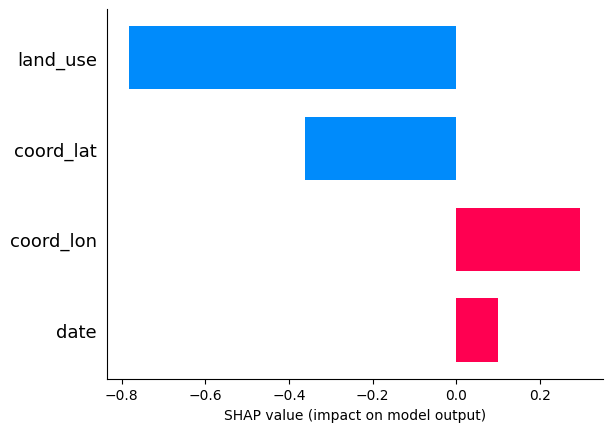

In [80]:
shap.initjs()
shap_values_dp = explainer.shap_values(bergpieper_landuse_test[['date', 'coord_lat', 'coord_lon', 'Numerical_LUSE']].iloc[2])
shap.bar_plot(shap_values_dp, feature_names=['date', 'land_use', 'coord_lon', 'coord_lat'])

In [73]:
bergpieper_landuse_test.iloc[3]

date                     77
coord_lat         46.163578
coord_lon          8.855934
Numerical_LUSE            6
LUSE                  Water
Name: 511, dtype: object

# 4️⃣ Model V3: Coordinates, Dates & Atlas Codes

In [ ]:
bergpieper_train = train_data[train_data.name_species == 'Bergpieper'][['date', 'coord_lat', 'coord_lon', 'atlas_code']]
bergpieper_test = validata[validata.name_species == 'Bergpieper'][['date', 'coord_lat', 'coord_lon', 'atlas_code']]

In [ ]:
bergpieper_train.date = pd.to_datetime(bergpieper_train.date).dt.dayofyear
bergpieper_test.date = pd.to_datetime(bergpieper_test.date).dt.dayofyear

In [ ]:
bergpieper_train.atlas_code = condense_atlas_codes(bergpieper_train.atlas_code)
bergpieper_test.atlas_code = condense_atlas_codes(bergpieper_test.atlas_code)

In [ ]:
model = IsolationForest(contamination='auto', random_state=0)
model.fit(bergpieper_train)

anomalies = model.predict(bergpieper_test)
falsified_data_atlas_codes = bergpieper_test[anomalies == -1]  # inliers=1; outliers=-1

In [ ]:
print('Number of detected anomalies:', len(falsified_data_atlas_codes), '/', len(bergpieper_test))
print('Percentage of anomalies:', round(len(falsified_data_atlas_codes)/len(bergpieper_test)*100,2), '%')

Number of detected anomalies: 3515 / 6431
Percentage of anomalies: 54.66 %


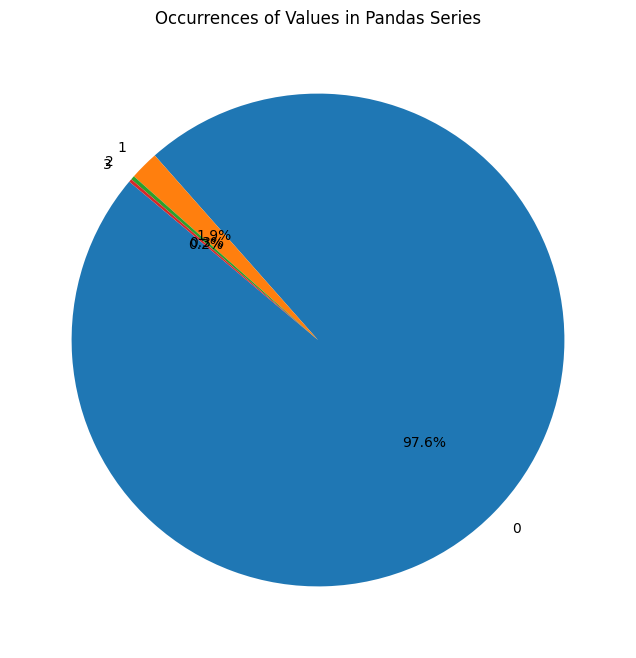

In [ ]:
import matplotlib.pyplot as plt

value_counts = bergpieper_train.atlas_code.value_counts()

# Plot the occurrences as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Atlas Codes occurrences in training data')
plt.show()

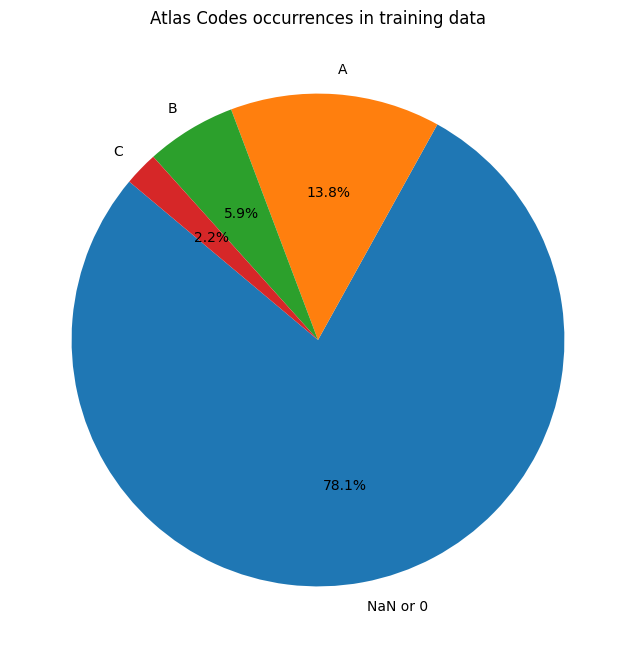

In [7]:
import matplotlib.pyplot as plt

path_train = '../../../01_Data/datasets/selected_species_with_50km_grids.csv'
train_data_atlas = pd.read_csv(path_train, index_col=0, low_memory=False).reset_index(drop=True)

train_data_atlas.atlas_code = condense_atlas_codes(train_data_atlas.atlas_code)
value_counts = train_data_atlas.atlas_code.value_counts()
labels = ['NaN or 0', 'A', 'B', 'C']

# Plot the occurrences as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Atlas Codes occurrences in training data')
plt.show()

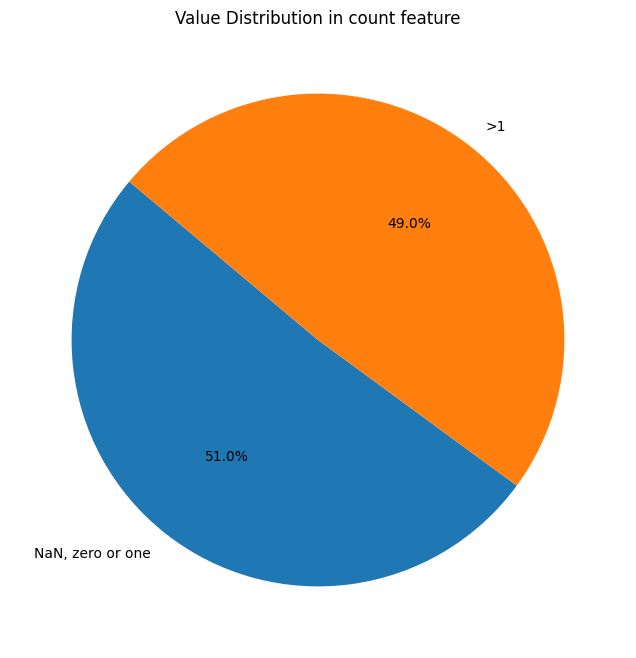

In [5]:
import matplotlib.pyplot as plt

count_one = train_data_atlas['total_count'].value_counts().get(1, 0) + train_data_atlas['total_count'].value_counts().get(0, 0) + train_data_atlas['total_count'].isnull().sum()
not_one = len(train_data_atlas) - count_one

labels = ['NaN, zero or one', '>1']
sizes = [count_one, not_one]

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Value Distribution in count feature')
plt.show()

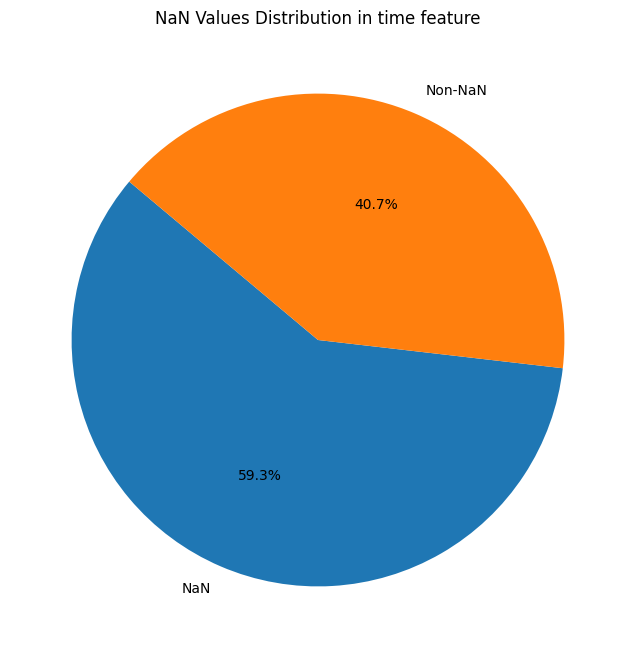

In [3]:
nan_count = train_data_atlas['timing'].isnull().sum()
non_nan_count = len(train_data_atlas) - nan_count

labels = ['NaN', 'Non-NaN']
sizes = [nan_count, non_nan_count]

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('NaN Values Distribution in time feature')
plt.show()

# V4 - Elevation

In [11]:
train_data

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country,eea_grid_id,Numerical_LUSE,LUSE
0,29666972,8.0,Haubentaucher,2018-01-01,NaN,53.157760,8.676993,place,-1.051010,0.0,0,37718.0,de,50kmE4200N3300,6,Water
1,29654244,397.0,Schwarzkehlchen,2018-01-01,NaN,53.127639,8.957263,square,0.760781,2.0,0,37803.0,de,50kmE4250N3300,3,Agriculture
2,29654521,463.0,Wiesenpieper,2018-01-01,NaN,50.850941,12.146953,place,270.831300,2.0,0,39627.0,de,50kmE4450N3050,1,Urban
3,29666414,8.0,Haubentaucher,2018-01-01,NaN,51.076006,11.038316,place,158.941010,8.0,0,38301.0,de,50kmE4350N3100,6,Water
4,29656211,8.0,Haubentaucher,2018-01-01,NaN,51.389380,7.067282,place,52.362160,10.0,0,108167.0,de,50kmE4100N3100,1,Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660038,27523548,469.0,Bergpieper,2022-08-01,09:35:04,46.563896,8.551648,precise,2099.035000,4.0,0,11482.0,ch,50kmE4200N2600,5,Grassland
2660039,27523686,338.0,Mittelspecht,2022-10-08,09:17:16,47.383318,7.666533,precise,802.159700,1.0,0,11482.0,ch,50kmE4100N2650,3,Agriculture
2660040,15002272,123.0,Bergente,2018-02-17,NaN,47.512154,9.436332,precise,391.370000,1.0,0,11245.0,ch,50kmE4250N2700,6,Water
2660041,15002282,8.0,Haubentaucher,2018-02-17,NaN,47.512154,9.436332,precise,391.370000,NaN,0,11245.0,ch,50kmE4250N2700,6,Water


In [15]:
bergpieper_train = train_data[train_data.name_species == 'Bergpieper'][['date', 'coord_lat', 'coord_lon', 'altitude']]
bergpieper_test = validata[validata.name_species == 'Bergpieper'][['date', 'coord_lat', 'coord_lon', 'altitude']]

In [19]:
bergpieper_train.date = pd.to_datetime(bergpieper_train.date).dt.dayofyear
bergpieper_test.date = pd.to_datetime(bergpieper_test.date).dt.dayofyear

In [22]:
model = IsolationForest(contamination='auto', random_state=0)
model.fit(bergpieper_train[['date', 'coord_lat', 'coord_lon', 'altitude']])

anomalies = model.predict(bergpieper_test[['date', 'coord_lat', 'coord_lon', 'altitude']])
falsified_data = bergpieper_test[anomalies == -1]  # inliers=1; outliers=-1

 97%|=================== | 6257/6431 [00:29<00:00]       

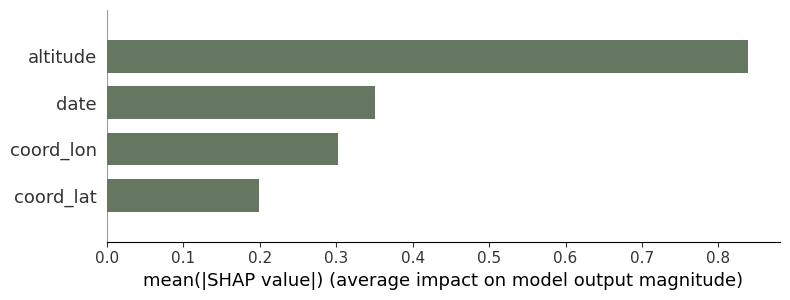

In [23]:
explainer = shap.Explainer(model, bergpieper_test[['date', 'coord_lat', 'coord_lon', 'altitude']])
shap_values = explainer.shap_values(bergpieper_test[['date', 'coord_lat', 'coord_lon', 'altitude']])

shap.summary_plot(shap_values, bergpieper_test[['date', 'coord_lat', 'coord_lon', 'altitude']], feature_names=['date', 'coord_lat', 'coord_lon', 'altitude'], plot_type='bar', color='#667761')